In [ ]:
import pandas as pd
import math
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def a1c_level(x):
  if math.isnan(x):
    return 'unknown'
  elif x <= 5.9:
    return 'low'
  elif x <= 6.2:
    return 'med'
  elif x > 6.2:
    return 'high'

def plot_data(data):
  fig, axes = plt.subplots(2, 3, figsize=(20,8))
  sns.countplot(x=data.RACE, ax=axes[0, 0])
  sns.countplot(x=data.GENDER, ax=axes[0, 1])
  sns.countplot(x=data.EDUCATION, ax=axes[0, 2])
  sns.histplot(x=data.INCOME, ax=axes[1, 0])
  sns.countplot(x=data.Prediabetes, ax=axes[1, 1])
  sns.countplot(x=data.Diabetes, ax=axes[1, 2])
  fig.show()

def load_data(run_name, plot=True):
  data = pd.read_csv('drive/MyDrive/2021 HHS Data Challenge/Data/'+run_name+'/all_patients.csv')
  data = data[['RACE', 'ETHNICITY', 'GENDER', 'FIRST_LANGUAGE', 'SOCIOECONOMIC_CATEGORY', 'SOCIOECONOMIC_SCORE', 'INCOME', 'INCOME_LEVEL', 'EDUCATION', 'EDUCATION_LEVEL', 'ACTIVE_WEIGHT_MANAGEMENT', 'BMI_PERCENTILE', 'SMOKER', 'ALCOHOLIC', 'HEALTHCARE_COVERAGE', 'FOOD_INSECURITY', 'SEVERE_HOUSING_COST_BURDEN', 'UNEMPLOYED', 'NO_VEHICLE_ACCESS', 'UNINSURED', 'AGE', 'Prediabetes', 'Diabetes', 'Obesity', 'Severely_Obesity', 'A1c_max']]
  data.RACE = data.RACE.astype('category')
  data.ETHNICITY = data.ETHNICITY.astype('category')
  data.GENDER = data.GENDER.astype('category')
  data.EDUCATION = data.EDUCATION.astype('category')
  data.FOOD_INSECURITY = data.FOOD_INSECURITY.astype('boolean')
  data.Obesity = data.Obesity.astype('boolean')
  data.Severely_Obesity = data.Severely_Obesity.astype('boolean')

  if plot is True:
    plot_data(data)

  return data

def prepare_dataset(data, sdoh=True):
  if sdoh is True:
    subset_data = data[['RACE', 'ETHNICITY', 'GENDER', 'EDUCATION', 'FOOD_INSECURITY', 'SEVERE_HOUSING_COST_BURDEN', 'UNEMPLOYED', 'NO_VEHICLE_ACCESS', 'UNINSURED', 'Obesity', 'Prediabetes', 'Diabetes', 'A1c_max']]
  else:
    subset_data = data[['RACE', 'ETHNICITY', 'GENDER', 'Obesity', 'Prediabetes', 'Diabetes', 'A1c_max']]
  subset_data = subset_data[subset_data['Prediabetes']==True]
  subset_data['A1c_max'] = subset_data['A1c_max'].apply(lambda x: a1c_level(x))

  #print(subset_data.isnull().sum(axis = 0))
  subset_data = subset_data.dropna()

  # encode categorical veriables
  d = defaultdict(LabelEncoder)
  fit = subset_data.apply(lambda x: d[x.name].fit_transform(x))
  fit.apply(lambda x: d[x.name].inverse_transform(x))
  test_data=subset_data.apply(lambda x: d[x.name].transform(x))

  if sdoh is True:
    test_data['INCOME_LEVEL'] = data.INCOME_LEVEL
  test_data['AGE'] = data.AGE
  test_data['BMI_PERCENTILE'] = data.BMI_PERCENTILE
  return test_data.dropna()

def train_and_evaluate(run_name, sdoh=True):
  data = load_data(run_name)
  dataset = prepare_dataset(data, sdoh)

  X = dataset.drop(columns=['Prediabetes', 'Diabetes'])
  y = dataset['Diabetes']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1234)

  logreg = LogisticRegression(max_iter=1000)
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)

  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("F1:", f1_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print('Balanced accuracy score:', roc_auc_score(y_test, y_pred))
  pd.set_option('display.max_columns', None)
  print(pd.DataFrame(np.exp(logreg.coef_), columns=X.columns))

Accuracy: 0.7759656411408039
F1: 0.48433158880920074
Precision: 0.709445390876396
Recall: 0.3676672552481852
Balanced accuracy score: 0.6536527389099754
      RACE  ETHNICITY    GENDER  EDUCATION  FOOD_INSECURITY  \
0  0.93771    0.99209  0.957294   0.966522         1.050904   

   SEVERE_HOUSING_COST_BURDEN  UNEMPLOYED  NO_VEHICLE_ACCESS  UNINSURED  \
0                    0.998986    0.876369           0.999798   0.993117   

    Obesity   A1c_max  INCOME_LEVEL       AGE  BMI_PERCENTILE  
0  0.968734  2.210185      0.978952  1.017207        0.999946  
CPU times: user 14.1 s, sys: 3.27 s, total: 17.3 s
Wall time: 13.7 s


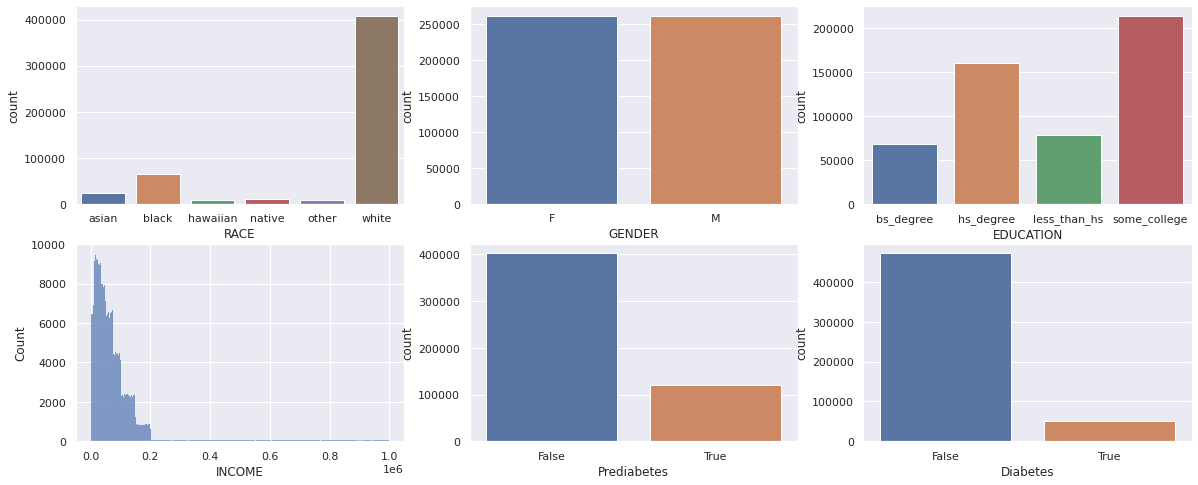

In [ ]:
%%time
train_and_evaluate('sample_10k_diabetes_education', sdoh=True)


Accuracy: 0.7762010552624271
F1: 0.4843560048627551
Precision: 0.7103978978978979
Recall: 0.367440054363654
Balanced accuracy score: 0.6537110808984243
       RACE  ETHNICITY    GENDER   Obesity   A1c_max      AGE  BMI_PERCENTILE
0  0.943997   1.027329  0.964962  0.984819  2.222459  1.01741        0.999682
CPU times: user 10.2 s, sys: 1.64 s, total: 11.9 s
Wall time: 10.7 s


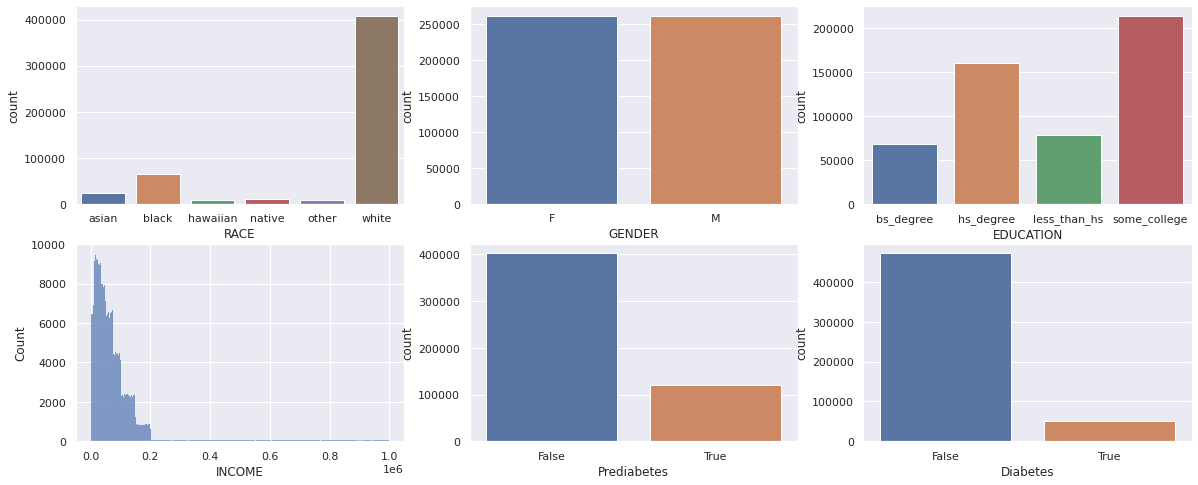

In [ ]:
%%time
train_and_evaluate('sample_10k_diabetes_education', sdoh=False)


Accuracy: 0.792396294361822
F1: 0.2953909311438701
Precision: 0.7044948820649756
Recall: 0.18687286034706646
Balanced accuracy score: 0.5815393471089593
       RACE  ETHNICITY    GENDER  EDUCATION  FOOD_INSECURITY  \
0  0.909101   1.002737  0.955186   1.005307         1.030139   

   SEVERE_HOUSING_COST_BURDEN  UNEMPLOYED  NO_VEHICLE_ACCESS  UNINSURED  \
0                    1.035606     1.03257            1.02113   0.980619   

   Obesity   A1c_max  INCOME_LEVEL       AGE  BMI_PERCENTILE  
0  0.96734  2.276846       0.98435  1.018444        0.999705  
CPU times: user 15.5 s, sys: 3.85 s, total: 19.4 s
Wall time: 14.7 s


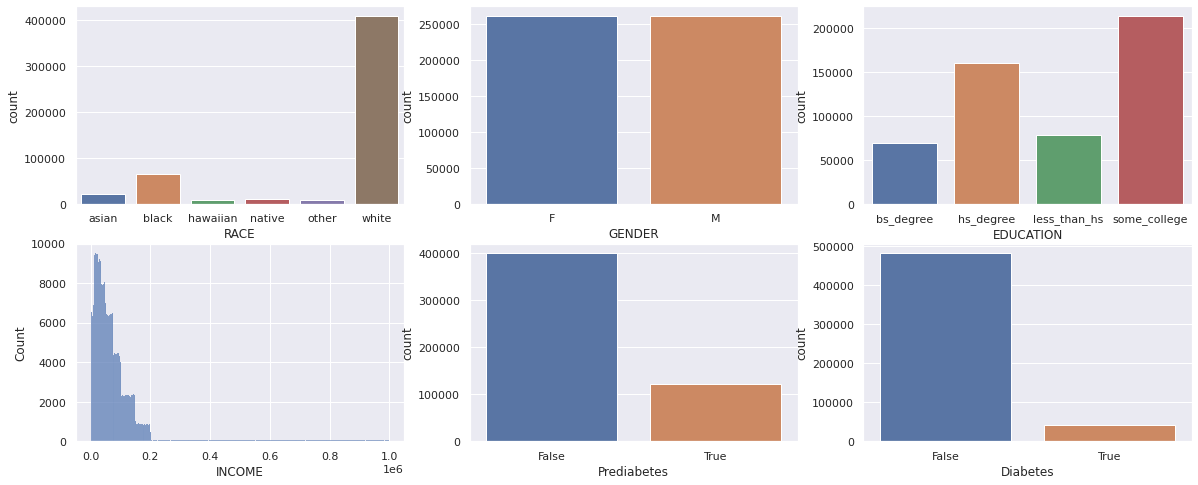

In [ ]:
%%time
train_and_evaluate('sample_10k_gender_age_run2', sdoh=True)


Accuracy: 0.7929515418502202
F1: 0.306178239475123
Precision: 0.6970954356846473
Recall: 0.19617001401214385
Balanced accuracy score: 0.5851463327770752
       RACE  ETHNICITY    GENDER   Obesity   A1c_max       AGE  BMI_PERCENTILE
0  0.908206   0.977374  0.976972  0.965206  2.283797  1.018965        0.999558
CPU times: user 10.2 s, sys: 1.62 s, total: 11.9 s
Wall time: 10.6 s


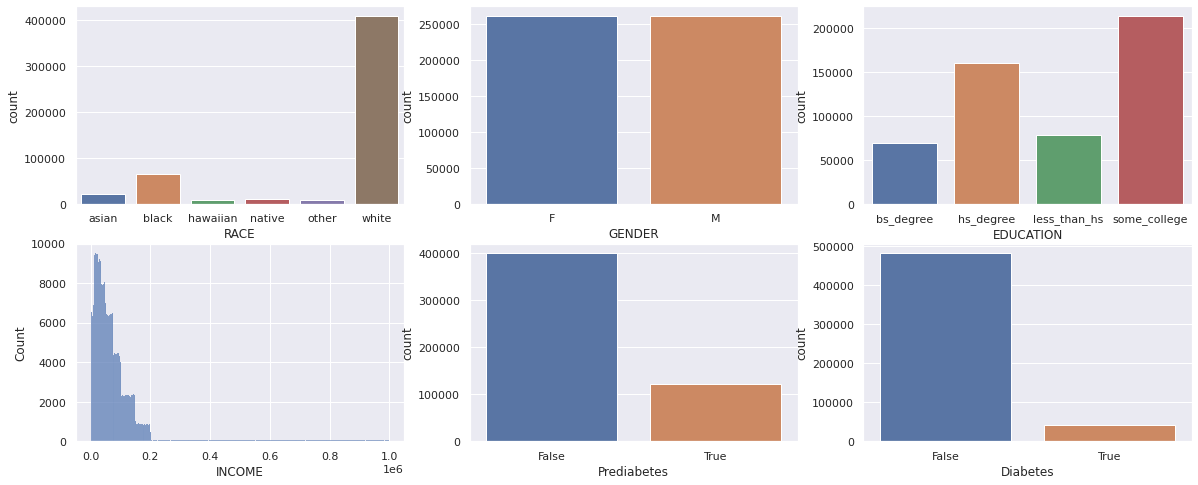

In [ ]:
%%time
train_and_evaluate('sample_10k_gender_age_run2', sdoh=False)


Accuracy: 0.8273526615969582
F1: 0.14805042509527996
Precision: 0.6824324324324325
Recall: 0.08303189740217033
Balanced accuracy score: 0.5372559240473256
       RACE  ETHNICITY    GENDER  EDUCATION  FOOD_INSECURITY  \
0  0.882958   1.059226  1.033998   0.997352         0.981297   

   SEVERE_HOUSING_COST_BURDEN  UNEMPLOYED  NO_VEHICLE_ACCESS  UNINSURED  \
0                    1.006194     1.00949           1.028549   1.037336   

    Obesity   A1c_max  INCOME_LEVEL       AGE  BMI_PERCENTILE  
0  0.959796  2.291295      1.037826  1.020257        0.998948  
CPU times: user 15.3 s, sys: 4 s, total: 19.3 s
Wall time: 14.6 s


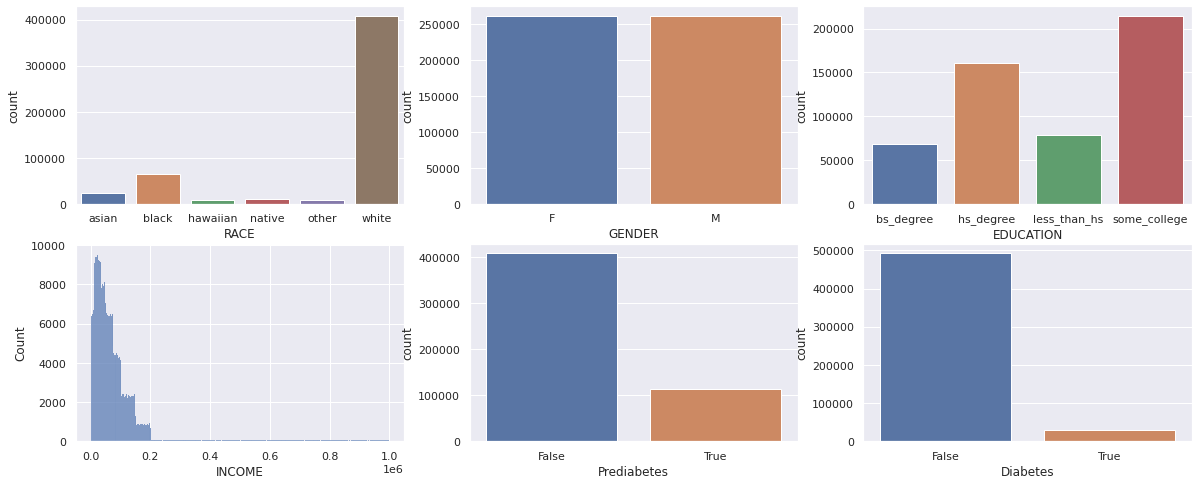

In [ ]:
%%time
train_and_evaluate('sample_10k_diabetes_age', sdoh=True)


Accuracy: 0.8275588468659085
F1: 0.14135206321334504
Precision: 0.7040816326530612
Recall: 0.07856213402732595
Balanced accuracy score: 0.5356405950076373
       RACE  ETHNICITY    GENDER  Obesity   A1c_max       AGE  BMI_PERCENTILE
0  0.887799   1.054931  1.020994  0.97672  2.288488  1.019926        0.998764
CPU times: user 10.1 s, sys: 1.54 s, total: 11.6 s
Wall time: 10.4 s


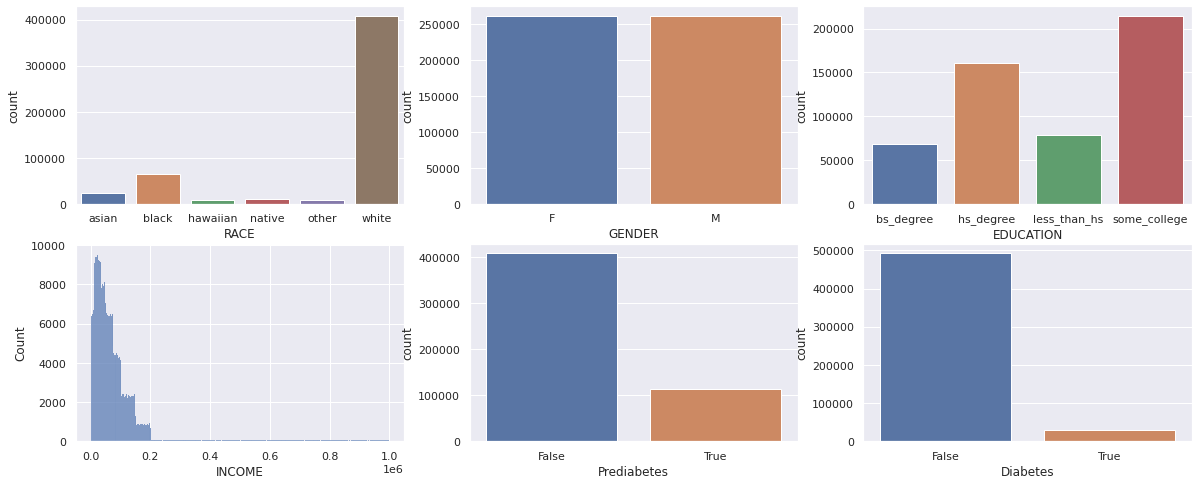

In [ ]:
%%time
train_and_evaluate('sample_10k_diabetes_age', sdoh=False)


Accuracy: 0.8741274103002197
F1: 0.020140604218126544
Precision: 0.45689655172413796
Recall: 0.010297260540120458
Balanced accuracy score: 0.5042693069303064
       RACE  ETHNICITY    GENDER  EDUCATION  FOOD_INSECURITY  \
0  0.852238   1.005707  0.993071   0.996866         1.001275   

   SEVERE_HOUSING_COST_BURDEN  UNEMPLOYED  NO_VEHICLE_ACCESS  UNINSURED  \
0                    1.020573    0.952285            0.98439   1.027507   

   Obesity   A1c_max  INCOME_LEVEL       AGE  BMI_PERCENTILE  
0  1.00393  2.234641      1.051881  1.021244        1.000154  
CPU times: user 16 s, sys: 4.41 s, total: 20.4 s
Wall time: 15 s


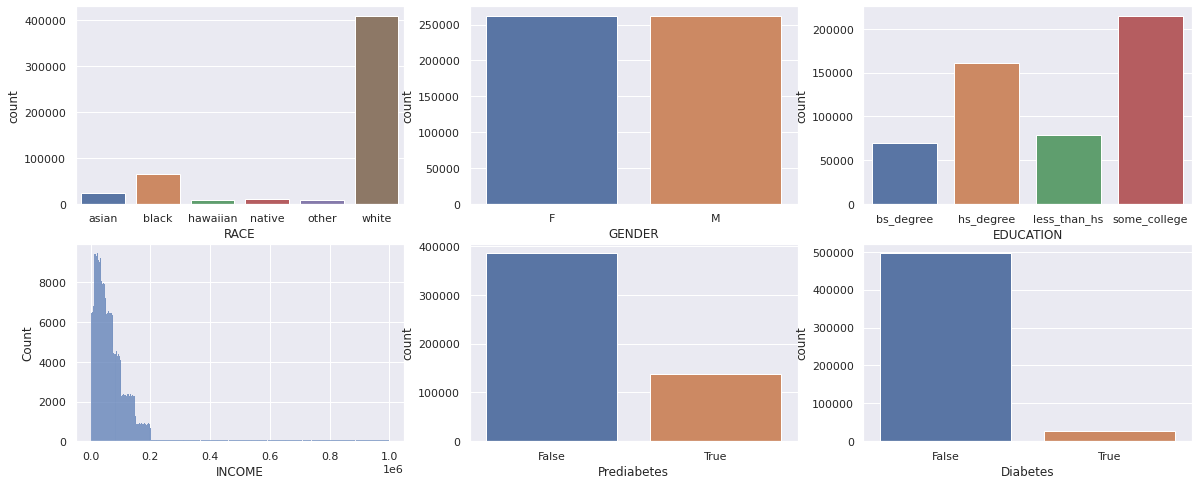

In [ ]:
%%time
train_and_evaluate('sample_10k_run3', sdoh=True)


Accuracy: 0.8742420948377901
F1: 0.018846588767433094
Precision: 0.45045045045045046
Recall: 0.009624639076034648
Balanced accuracy score: 0.5039698246482323
       RACE  ETHNICITY    GENDER   Obesity   A1c_max       AGE  BMI_PERCENTILE
0  0.843059   1.043345  0.988457  0.990892  2.204457  1.021242        0.999995
CPU times: user 10.4 s, sys: 1.69 s, total: 12.1 s
Wall time: 10.8 s


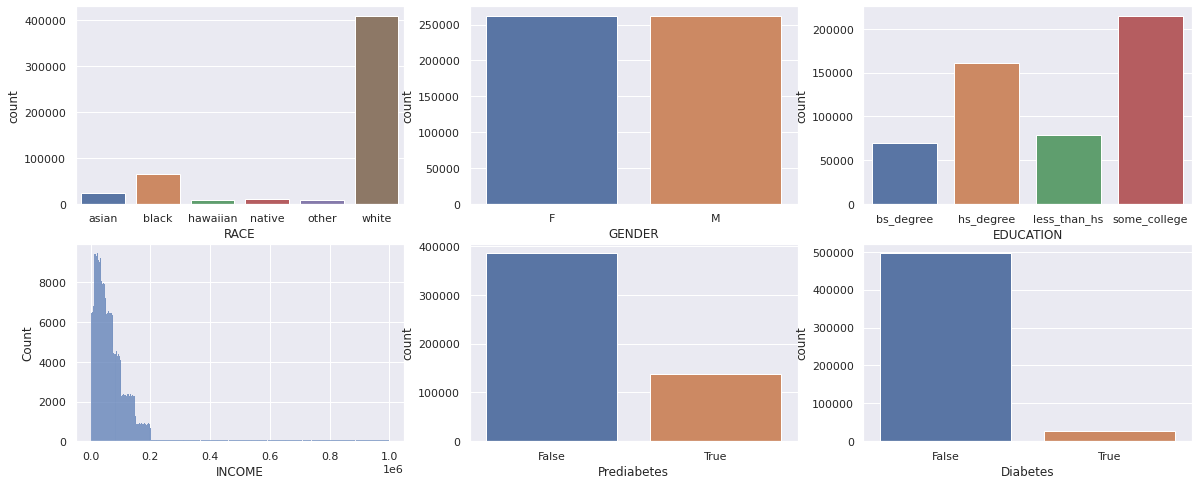

In [ ]:
%%time
train_and_evaluate('sample_10k_run3', sdoh=False)
